In [1]:
import os
os.environ["DATA_PATH"] = "/home/jupyter-chenxi/proteina/data"
import hydra
import lightning as L
import numpy as np
import pandas as pd
import torch
from proteinfoundation.datasets.transforms import CATHLabelTransform
from tqdm import tqdm
from matplotlib import pyplot as plt


/home/jupyter-chenxi/.conda/envs/proteina/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
seq_cath_lora_r8_aln_df = pd.read_csv("/home/jupyter-chenxi/proteina/inference/inference_seq_cath_cond_sampling_21-seq_lora-r8/4jnj_A/aln.tsv", sep="\t")
seq_cath_aln_df = pd.read_csv("/home/jupyter-chenxi/proteina/inference/inference_seq_cath_cond_sampling_21-seq/4jnj_A/aln.tsv", sep="\t")
seq_aln_df = pd.read_csv("/home/jupyter-chenxi/proteina/inference/inference_seq_cond_sampling_21-seq/4jnj_A/aln.tsv", sep="\t")
seq_lora_r8_aln_df = pd.read_csv("/home/jupyter-chenxi/proteina/inference/inference_seq_cond_sampling_21-seq_lora-r8/4jnj_A/aln.tsv", sep="\t")
seq_lora_r4_aln_df = pd.read_csv("/home/jupyter-chenxi/proteina/inference/inference_seq_cond_sampling_21-seq_lora-r4/4jnj_A/aln.tsv", sep="\t")
seq_lora_r2_aln_df = pd.read_csv("/home/jupyter-chenxi/proteina/inference/inference_seq_cond_sampling_21-seq_lora-r2/4jnj_A/aln.tsv", sep="\t")


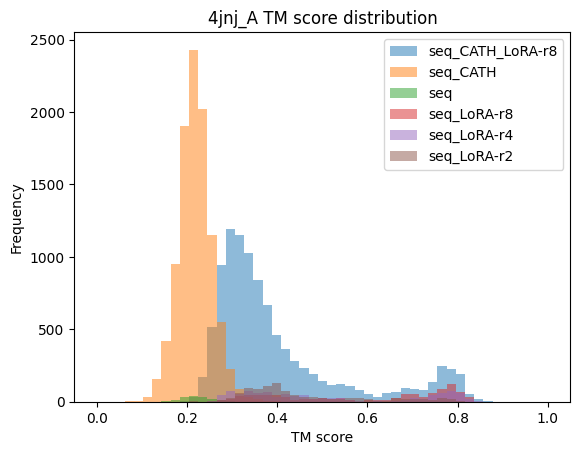

In [3]:
plt.hist(seq_cath_lora_r8_aln_df["TM1"].to_numpy(), alpha=0.5, bins=np.linspace(0, 1, 50), label="seq_CATH_LoRA-r8")
plt.hist(seq_cath_aln_df["TM1"].to_numpy(), alpha=0.5, bins=np.linspace(0, 1, 50), label="seq_CATH")
plt.hist(seq_aln_df["TM1"].to_numpy(), alpha=0.5, bins=np.linspace(0, 1, 50), label="seq")
plt.hist(seq_lora_r8_aln_df["TM1"].to_numpy(), alpha=0.5, bins=np.linspace(0, 1, 50), label="seq_LoRA-r8")
plt.hist(seq_lora_r4_aln_df["TM1"].to_numpy(), alpha=0.5, bins=np.linspace(0, 1, 50), label="seq_LoRA-r4")
plt.hist(seq_lora_r2_aln_df["TM1"].to_numpy(), alpha=0.5, bins=np.linspace(0, 1, 50), label="seq_LoRA-r2")
plt.xlabel("TM score")
plt.ylabel("Frequency")
plt.title("4jnj_A TM score distribution")
plt.legend()
plt.show()


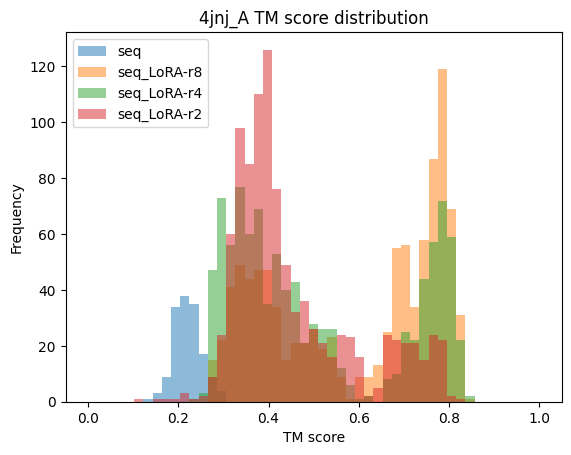

In [4]:
plt.hist(seq_aln_df["TM1"].to_numpy(), alpha=0.5, bins=np.linspace(0, 1, 50), label="seq")
plt.hist(seq_lora_r8_aln_df["TM1"].to_numpy(), alpha=0.5, bins=np.linspace(0, 1, 50), label="seq_LoRA-r8")
plt.hist(seq_lora_r4_aln_df["TM1"].to_numpy(), alpha=0.5, bins=np.linspace(0, 1, 50), label="seq_LoRA-r4")
plt.hist(seq_lora_r2_aln_df["TM1"].to_numpy(), alpha=0.5, bins=np.linspace(0, 1, 50), label="seq_LoRA-r2")
plt.xlabel("TM score")
plt.ylabel("Frequency")
plt.title("4jnj_A TM score distribution")
plt.legend()
plt.show()

In [2]:
seq_lora_r8_purge_7bny_aln_df = pd.read_csv("/home/jupyter-chenxi/proteina/inference/inference_seq_cond_sampling_21-seq_lora-r8_purge-7bny/7bny_A/aln.tsv", sep="\t")
seq_lora_r4_purge_7bny_aln_df = pd.read_csv("/home/jupyter-chenxi/proteina/inference/inference_seq_cond_sampling_21-seq_lora-r4_purge-7bny/7bny_A/aln.tsv", sep="\t")
seq_lora_r2_purge_7bny_aln_df = pd.read_csv("/home/jupyter-chenxi/proteina/inference/inference_seq_cond_sampling_21-seq_lora-r2_purge-7bny/7bny_A/aln.tsv", sep="\t")


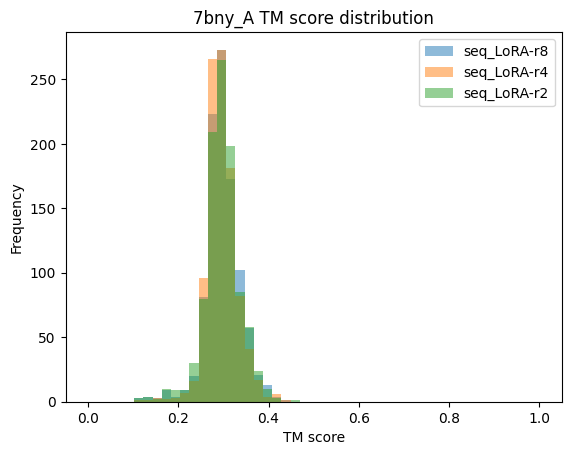

In [3]:
plt.hist(seq_lora_r8_purge_7bny_aln_df["TM1"].to_numpy(), alpha=0.5, bins=np.linspace(0, 1, 50), label="seq_LoRA-r8")
plt.hist(seq_lora_r4_purge_7bny_aln_df["TM1"].to_numpy(), alpha=0.5, bins=np.linspace(0, 1, 50), label="seq_LoRA-r4")
plt.hist(seq_lora_r2_purge_7bny_aln_df["TM1"].to_numpy(), alpha=0.5, bins=np.linspace(0, 1, 50), label="seq_LoRA-r2")
plt.xlabel("TM score")
plt.ylabel("Frequency")
plt.title("7bny_A TM score distribution")
plt.legend()
plt.show()


In [8]:
split_df = pd.DataFrame(["2.40.128"], columns=["cath_code"])
split_df.to_csv(f"/home/jupyter-chenxi/proteina/data/pdb_train/test_cath_code.csv", index=False)

In [5]:
cath_transform = CATHLabelTransform(root_dir="/home/jupyter-chenxi/proteina/data/cathdata/")
pdbchain_to_cathid_mapping = cath_transform.pdbchain_to_cathid_mapping
cathid_to_cathcode_mapping = cath_transform.cathid_to_cathcode_mapping
cathid_to_segment_mapping = cath_transform.cathid_to_segment_mapping


2025-05-12 16:57:16.148 | INFO     | proteinfoundation.datasets.transforms:__init__:231 - Processing Uniprot/PDB CATH map...
2025-05-12 16:57:16.713 | INFO     | proteinfoundation.datasets.transforms:__init__:233 - Processing CATH ID to CATH code map...


In [6]:
print(len(pdbchain_to_cathid_mapping))
print(list(pdbchain_to_cathid_mapping.keys())[:10])
print(pdbchain_to_cathid_mapping[list(pdbchain_to_cathid_mapping.keys())[1]])


296383
['PDB_CHAIN', '101m_A', '102l_A', '102m_A', '103l_A', '103m_A', '104l_A', '104l_B', '104m_A', '105m_A']
['101mA00']


In [7]:
print(len(cathid_to_cathcode_mapping))
print(list(cathid_to_cathcode_mapping.keys())[:10])
print(cathid_to_cathcode_mapping[list(cathid_to_cathcode_mapping.keys())[1]])


601328
['101mA00', '102lA00', '102mA00', '103lA00', '103mA00', '104lA00', '104lB00', '104mA00', '105mA00', '106mA00']
1.10.530.40


In [8]:
print(len(cathid_to_segment_mapping))
print(list(cathid_to_segment_mapping.keys())[:10])
print(cathid_to_segment_mapping[list(cathid_to_segment_mapping.keys())[1]])


601328
['101mA00', '102lA00', '102mA00', '103lA00', '103mA00', '104lA00', '104lB00', '104mA00', '105mA00', '106mA00']
[('A', '1', '162')]


In [16]:
print(len(list(filter(lambda x: x[-2:] != "00", list(cathid_to_cathcode_mapping.keys())))))


396636


In [29]:
for split in ["train", "val", "test"]:
    pdbs = pdb_datamodule._get_dataset(split).pdb_codes
    chains = pdb_datamodule._get_dataset(split).chains
    pdb_chains = set([f"{pdb}{chain}" for pdb, chain in zip(pdbs, chains)])
    cath = set()
    for cathid, cathcode in tqdm(cathid_to_cathcode_mapping.items()):
        if cathid[:5] in pdb_chains:
            cath.add(cathcode)
    print(f"{split} has {len(cath)} unique CATH codes")
    split_df = pd.DataFrame(list(cath), columns=["cath_code"])
    split_df.to_csv(f"/home/jupyter-chenxi/proteina/data/pdb_train/cath_codes_{split}_0.5_df_pdb_f1_minl50_maxl256_mtprotein_etdiffractionEM_minoNone_maxoNone_minr0.0_maxr5.0_hl_rl_rnsrTrue_rpuTrue_l_rcuFalse.csv", index=False)


100%|██████████| 601328/601328 [00:00<00:00, 1730785.42it/s]


train has 3330 unique CATH codes


100%|██████████| 601328/601328 [00:00<00:00, 2671927.32it/s]


val has 213 unique CATH codes


100%|██████████| 601328/601328 [00:00<00:00, 2678277.25it/s]

test has 16 unique CATH codes


In [2]:
L.seed_everything(43)
version_base = hydra.__version__
config_path = "/home/jupyter-chenxi/proteina/configs/datasets_config"
hydra.initialize_config_dir(config_dir=f"{config_path}/pdb", version_base=version_base)

cfg = hydra.compose(
    config_name="pdb_train",
    return_hydra_config=True,
)
pdb_datamodule = hydra.utils.instantiate(cfg.datamodule)
pdb_datamodule.prepare_data()
pdb_datamodule.setup("fit")
pdb_train_dataloader = pdb_datamodule.train_dataloader()


Seed set to 43
2025-05-12 20:03:08.833 | INFO     | proteinfoundation.datasets.transforms:__init__:231 - Processing Uniprot/PDB CATH map...
2025-05-12 20:03:09.396 | INFO     | proteinfoundation.datasets.transforms:__init__:233 - Processing CATH ID to CATH code map...
2025-05-12 20:03:11.470 | INFO     | proteinfoundation.datasets.pdb_data:prepare_data:518 - df_pdb_f1_minl50_maxl256_mtprotein_etdiffractionEM_minoNone_maxoNone_minr0.0_maxr5.0_hl_rl_rnsrTrue_rpuTrue_l_rcuFalse.csv already exists, skipping data selection and processing stage.
2025-05-12 20:03:11.471 | INFO     | proteinfoundation.datasets.pdb_data:setup:609 - Loading dataset csv from df_pdb_f1_minl50_maxl256_mtprotein_etdiffractionEM_minoNone_maxoNone_minr0.0_maxr5.0_hl_rl_rnsrTrue_rpuTrue_l_rcuFalse.csv
2025-05-12 20:03:12.074 | INFO     | proteinfoundation.datasets.pdb_data:split_data:286 - Splitting dataset via sequence-similarity split into [0.98, 0.019, 0.001]...
2025-05-12 20:03:12.074 | INFO     | proteinfoundation

In [7]:
pt_name = "/home/jupyter-chenxi/proteina/data/pdb_train/processed/4jnj_A.pt"
load_pt = torch.load(pt_name)
print(load_pt.residue_type)

tensor([ 7,  0,  6,  0,  7,  9, 16,  7, 16, 17, 18,  2,  5, 15,  7, 15, 16, 13,
        16, 19, 16,  0,  7,  0,  3,  7,  2, 10, 16,  7,  5, 18,  6,  2,  1,  0,
         5,  7, 16,  7,  4,  5,  2, 15, 14, 18, 16, 10, 16,  7,  1, 18,  2,  7,
        16, 11, 10,  6, 17,  1, 19,  6, 17,  2,  2, 15, 16,  6,  2,  4,  8, 15,
         1, 16,  6, 17,  1,  7,  5, 18,  5,  7,  7,  0,  6,  0,  1,  9,  2, 16,
         5, 17,  2, 10, 16, 18,  6,  7,  7, 15,  7, 14,  0, 16,  6,  5,  7,  5,
         3, 16, 13, 16, 11, 19, 11])


/tmp/ipykernel_3145877/2087316723.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_pt = torch.load(pt_name)


In [10]:
train_id = pdb_datamodule._get_dataset("train").file_names
train_id

['9bce_A',
 '9bce_B',
 '6jx3_B',
 '8hfq_n',
 '4f8k_A',
 '3ngh_A',
 '3ngh_B',
 '4f8k_B',
 '4v3k_C',
 '4v3k_F',
 '4v3l_C',
 '7ojx_A',
 '6mjp_C',
 '2irp_A',
 '2irp_B',
 '8bwa_A',
 '8bwa_B',
 '8bwd_A',
 '8bwd_B',
 '8bwi_A',
 '8bwl_C',
 '8bwl_D',
 '8bwm_C',
 '8bwm_D',
 '8bwn_C',
 '8bwn_D',
 '8pxd_A',
 '8pxf_A',
 '8pxf_B',
 '4nob_A',
 '1xed_A',
 '1xed_B',
 '1xed_C',
 '1xed_D',
 '1xed_E',
 '1xed_F',
 '4obi_A',
 '8xgm_D',
 '8zjg_L',
 '9l3w_L',
 '9l3y_L',
 '1flm_A',
 '1flm_B',
 '1wli_A',
 '1wli_B',
 '1wlk_A',
 '1wlk_B',
 '1wlk_C',
 '1wlk_D',
 '2e83_A',
 '2e83_B',
 '3a20_A',
 '3a20_B',
 '3a6q_A',
 '3a6q_B',
 '3a6r_A',
 '3a6r_B',
 '3a6r_C',
 '3a6r_D',
 '3amf_A',
 '3amf_B',
 '3awh_A',
 '3awh_B',
 '3vy2_A',
 '3vy2_B',
 '3vy5_A',
 '3vy5_B',
 '3vya_A',
 '4dh2_A',
 '4dh2_C',
 '3mb2_A',
 '3mb2_C',
 '3mb2_E',
 '3mb2_G',
 '3mb2_I',
 '3mb2_K',
 '3ry0_A',
 '3ry0_B',
 '6ncv_A',
 '6ncv_B',
 '6ncv_C',
 '6ncv_D',
 '6ncv_E',
 '6ncv_F',
 '6ncv_G',
 '6ncv_H',
 '6ncv_I',
 '6ncv_J',
 '6ncv_K',
 '6ncv_L',
 '6ncv_M',

In [11]:
val_id = pdb_datamodule._get_dataset("val").file_names
val_id

['5dwu_A',
 '6nmy_A',
 '6nmy_C',
 '4jnj_A',
 '4jnj_B',
 '4jnj_C',
 '4jnj_D',
 '8rbz_B',
 '4owt_B',
 '4oww_B',
 '4owx_B',
 '5d8e_A',
 '5d8e_B',
 '5d8e_C',
 '5d8e_D',
 '5d8f_A',
 '5d8f_B',
 '3oga_A',
 '3n77_A',
 '3n77_B',
 '3oga_B',
 '6dt3_A',
 '6dt3_B',
 '6aow_A',
 '5lne_A',
 '5lne_B',
 '5lng_A',
 '5lng_B',
 '5lng_C',
 '5lng_D',
 '6aow_B',
 '6aox_A',
 '6aox_B',
 '6aoy_A',
 '6aoy_B',
 '6arm_A',
 '6arm_B',
 '6arn_A',
 '6arn_B',
 '6aro_A',
 '6aro_B',
 '6as8_A',
 '6as8_B',
 '6map_B',
 '6maq_B',
 '6maw_A',
 '8usm_A',
 '8usm_B',
 '2j23_A',
 '2j23_B',
 '5jy5_A',
 '5jy5_B',
 '6i19_A',
 '1ep7_A',
 '1ep7_B',
 '1ep8_A',
 '1ep8_B',
 '2yoi_A',
 '2yoi_B',
 '2ypm_A',
 '6i19_B',
 '6q46_A',
 '6q46_B',
 '6q47_A',
 '6q47_B',
 '6q6t_A',
 '6q6u_A',
 '6q6u_B',
 '6q6v_A',
 '6q6v_B',
 '1tw9_A',
 '1tw9_B',
 '1tw9_C',
 '1tw9_D',
 '1tw9_E',
 '1tw9_F',
 '1tw9_G',
 '1tw9_H',
 '2on5_A',
 '2on5_B',
 '2on5_C',
 '2on5_D',
 '2on5_E',
 '2on5_F',
 '2on5_G',
 '2on5_H',
 '8wm6_a',
 '8wmj_a',
 '8wmv_a',
 '8wmw_a',
 '3vol_A',

In [5]:
pdb_datamodule.df_data[pdb_datamodule.df_data["pdb"] == "7bny"]

,id,pdb,chain,length,molecule_type,name,sequence,split,n_chains,ligands,source,resolution,deposition_date,experiment_type,pdb_file_available
217865,7bny_A,7bny,A,152,protein,Genome polyprotein,SPNPLDVSKTYPTLHILLQFNHRGLEARIFRHGQLWAETHAEVVLR...,NaN,4,['SO4'],Mengo encephalomyocarditis virus,2.62,2021-01-22,diffraction,True
217866,7bny_B,7bny,B,152,protein,Genome polyprotein,SPNPLDVSKTYPTLHILLQFNHRGLEARIFRHGQLWAETHAEVVLR...,NaN,4,['SO4'],Mengo encephalomyocarditis virus,2.62,2021-01-22,diffraction,True
217867,7bny_C,7bny,C,152,protein,Genome polyprotein,SPNPLDVSKTYPTLHILLQFNHRGLEARIFRHGQLWAETHAEVVLR...,NaN,4,['SO4'],Mengo encephalomyocarditis virus,2.62,2021-01-22,diffraction,True
217868,7bny_D,7bny,D,152,protein,Genome polyprotein,SPNPLDVSKTYPTLHILLQFNHRGLEARIFRHGQLWAETHAEVVLR...,NaN,4,['SO4'],Mengo encephalomyocarditis virus,2.62,2021-01-22,diffraction,True


In [4]:
# print(pdb_datamodule.dataselector.exclude_ids, pdb_datamodule._get_dataset("train").file_names)
print(list(filter(lambda x: x in ["7bny_A", "7bny_B", "7bny_C", "7bny_D"], pdb_datamodule._get_dataset("train").file_names)))

['7bny_A', '7bny_B', '7bny_C', '7bny_D']


In [4]:
pdb_datamodule.df_data[pdb_datamodule.df_data["pdb"] == "7ll9"]

,id,pdb,chain,length,molecule_type,name,sequence,split,n_chains,ligands,source,resolution,deposition_date,experiment_type,pdb_file_available
231536,7ll9_A,7ll9,A,103,protein,Isoform L-VEGF189 of Vascular endothelial grow...,SGQNHHEVVKFMDVYQRSYCHPIETLVDIFQEYPDEIEYIFKPSCV...,NaN,8,"['DAL', 'DAR', 'DAS', 'DGL', 'DGN', 'DHI', 'DI...",Homo sapiens; SYNTHETIC CONSTRUCT,2.9,2021-02-03,diffraction,True
231537,7ll9_B,7ll9,B,103,protein,Isoform L-VEGF189 of Vascular endothelial grow...,SGQNHHEVVKFMDVYQRSYCHPIETLVDIFQEYPDEIEYIFKPSCV...,NaN,8,"['DAL', 'DAR', 'DAS', 'DGL', 'DGN', 'DHI', 'DI...",Homo sapiens; SYNTHETIC CONSTRUCT,2.9,2021-02-03,diffraction,True
231538,7ll9_E,7ll9,E,103,protein,Isoform L-VEGF189 of Vascular endothelial grow...,SGQNHHEVVKFMDVYQRSYCHPIETLVDIFQEYPDEIEYIFKPSCV...,NaN,8,"['DAL', 'DAR', 'DAS', 'DGL', 'DGN', 'DHI', 'DI...",Homo sapiens; SYNTHETIC CONSTRUCT,2.9,2021-02-03,diffraction,True
231539,7ll9_F,7ll9,F,103,protein,Isoform L-VEGF189 of Vascular endothelial grow...,SGQNHHEVVKFMDVYQRSYCHPIETLVDIFQEYPDEIEYIFKPSCV...,NaN,8,"['DAL', 'DAR', 'DAS', 'DGL', 'DGN', 'DHI', 'DI...",Homo sapiens; SYNTHETIC CONSTRUCT,2.9,2021-02-03,diffraction,True


In [5]:
print(pdb_train_dataloader.dataset[0])
print(pdb_train_dataloader.dataset[0].residues)
print(pdb_train_dataloader.dataset[0].residue_type)
print(pdb_train_dataloader.dataset[0].residue_pdb_idx)
print(pdb_train_dataloader.dataset[0].seq_pos)
print(pdb_train_dataloader.dataset[0].cath_code)


Data(coords=[256, 37, 3], residues=[208], id='9bce_A', residue_id=[208], residue_type=[256], chains=[256], bfactor=[256], coord_mask=[256, 37], database='pdb', bfactor_avg=19.72928620244606, residue_pdb_idx=[256], seq_pos=[256, 1], chain_breaks_per_residue=[256], cath_code=[0])
['ASP', 'VAL', 'SER', 'GLY', 'SER', 'LEU', 'ARG', 'ILE', 'ALA', 'ILE', 'PRO', 'VAL', 'SER', 'PHE', 'SER', 'GLN', 'GLU', 'LEU', 'ILE', 'ALA', 'ASN', 'LEU', 'CYS', 'SER', 'GLY', 'PHE', 'ARG', 'LEU', 'TYR', 'PRO', 'ASN', 'VAL', 'GLU', 'LEU', 'ASP', 'VAL', 'GLN', 'PHE', 'THR', 'ASP', 'ASN', 'ASP', 'ILE', 'GLY', 'LEU', 'VAL', 'GLY', 'GLU', 'GLY', 'TYR', 'ASP', 'ILE', 'ALA', 'ILE', 'LYS', 'TYR', 'GLY', 'PRO', 'LEU', 'GLN', 'SER', 'SER', 'ASP', 'LEU', 'VAL', 'ALA', 'ARG', 'LEU', 'LEU', 'PHE', 'GLU', 'ARG', 'GLN', 'PRO', 'ILE', 'LEU', 'VAL', 'ALA', 'SER', 'PRO', 'GLY', 'TYR', 'LEU', 'LYS', 'THR', 'ARG', 'GLY', 'THR', 'PRO', 'ALA', 'THR', 'PRO', 'LYS', 'GLU', 'LEU', 'SER', 'ASP', 'HIS', 'SER', 'GLY', 'ILE', 'LEU', 'LEU',

In [ ]:
len_cath_codes_lst = torch.load("/home/jupyter-chenxi/proteina/data/metric_factory/features/D_FS_afdb_cath_codes.pth")
print(len_cath_codes_lst)
print(filter(lambda x: x[0] == "4jnj", len_cath_codes_lst))

/tmp/ipykernel_3143434/2030198574.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  len_cath_codes_lst = torch.load("/home/jupyter-chenxi/proteina/data/metric_factory/feat

In [6]:
import importlib
import sys
from graphein_utils import graphein_utils
from graphein_utils.graphein_utils import protein_to_pyg

# Ensure the module is in sys.modules before reloading
if 'graphein_utils.graphein_utils' in sys.modules:
    importlib.reload(graphein_utils)

protein_to_pyg("/home/jupyter-chenxi/proteina/data/pdb_train/raw/7ll9.cif.gz", pdb_code="7ll9", chain_selection="C")


/home/jupyter-chenxi/proteina/graphein_utils/graphein_utils.py:492: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pd.Series(get_residue_id(df, unique=False))


TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint64, uint32, uint16, uint8, and bool.